In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy.stats.stats import pearsonr 
import math

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
import pandas as pd
import pickle

samples=pd.read_csv('TrainingSamples.csv')
samples.drop('Unnamed: 0', axis=1, inplace=True)

with open("stat_order.pickle",'rb') as f:
    stat_order=pickle.load(f)

Next, lets remove the first year of football data (since the averages will be bad) and extract all of the WR players

In [3]:
POSsamples=samples[(samples['Inferred Position']=="WR") & (samples['Week']>17)].reset_index(drop=True)

In [4]:
len(POSsamples)

13195

All of our lists got saved as strings in csv format, so lets convert them back to lists

In [5]:
all_lists = ['Opp Avg Stats','Opp Stat Std','Opp Avg Stats v Team','Opp Stat Std v Team',\
             'Opp Players','Player Avg Stats','Player Stat Std','Player Avg Stats v Opp',\
             'Player Stat Std v Opp','Team Avg Stats','Team Stat Std','Team Avg v Opp',\
             'Team Stat Std v Opp','Stat Outcome']

for list in all_lists:
    POSsamples[list] = POSsamples[list].apply(eval)

Next, lets remove any players that have "nan" stats

In [6]:
POSsamples['No Player Stats'] = POSsamples.apply(lambda x: math.isnan(x['Player Avg Stats'][0]), axis = 1)

In [7]:
POSsamples=POSsamples[POSsamples['No Player Stats']==False].reset_index(drop=True)

In [8]:
len(POSsamples)

12848

Now, let's calculate the fantasy points each player got in each sample incase we need to fall back to predicting points instead of stats.

In [9]:
point_dict={
    'passing_yds': 0.04,
    'passing_tds': 6,
    'passing_int': -2,
    'passing_twoptm': 2,
    'rushing_yds': 0.1,
    'rushing_tds': 6,
    'rushing_twoptm': 2,
    'receiving_yds': 0.1,
    'receiving_rec': 1,
    'receiving_tds': 6,
    'receiving_twoptm': 2,
    'kickret_tds': 6,
    'puntret_tds': 6,
    'fumbles_rec_tds': 6,
    'fumbles_lost': -2,
    'defense_int_tds': 6,
    'defense_frec_tds': 6,
    'defense_misc_tds': 6,
    'defense_sk': 1,
    'defense_puntblk': 2,
    'defense_fgblk': 2,
    'defense_xpblk': 2,
    'defense_int': 2,
    'defense_frec': 2,
    'defense_safe': 2,
    #No 2 pnt return data
    #No 1 pnt safety data
    #Need to figure out how to deal with defense points allowed and yds allowed
    'kicking_xpmade': 1,
    'kicking_fgmissed': -1,
    #Need to handle kicking yardage 
}

In [10]:
def CalcFantasyPoints(row):
    all_stats =  row['Stat Outcome']

    points = 0
    for stat in point_dict:
        points += all_stats[stat_order.index(stat)] * point_dict[stat]

    return points

In [11]:
POSsamples['FantasyPoints']=POSsamples.apply(CalcFantasyPoints,axis=1)

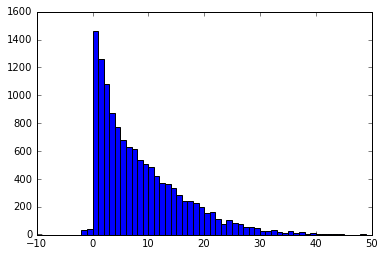

In [12]:
tarHist=np.hstack(POSsamples['FantasyPoints'].tolist())
plt.hist(tarHist, bins=range(-10,51,1))
plt.show()

In [13]:
def CalcAvgFantasyPoints(row):
    all_stats =  row['Player Avg Stats']

    points = 0
    for stat in point_dict:
        points += all_stats[stat_order.index(stat)] * point_dict[stat]

    return points

In [14]:
POSsamples['AvgFantasyPoints']=POSsamples.apply(CalcAvgFantasyPoints,axis=1)

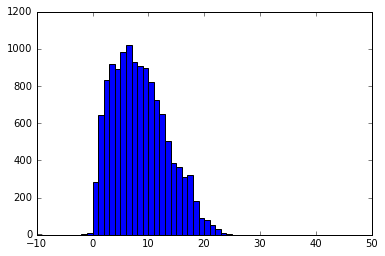

In [15]:
tarHist=np.hstack(POSsamples['AvgFantasyPoints'].tolist())
plt.hist(tarHist, bins=range(-10,51,1))
plt.show()

In [16]:
def CalcAvgVOppFantasyPoints(row):
    all_stats =  row['Player Avg Stats v Opp']

    points = 0
    for stat in point_dict:
        points += all_stats[stat_order.index(stat)] * point_dict[stat]

    return points

In [17]:
POSsamples['AvgVOppFantasyPoints']=POSsamples.apply(CalcAvgVOppFantasyPoints,axis=1)

# Examining feature correlations for fantasy points

Let's loop over each player's, team's, and opponents stats and see which are coorelated with the final outcome

In [18]:
def CalcCorrPoints(x_stat_type):
    #x_stat is a stat in stat_order, such as "receiving_yds"
    #x_stat_type is "Player" or "Team" or "Opp"
    for x_stat in stat_order:
        x_dfColumn = '%s Avg Stats' % x_stat_type

        all_x_stats =  POSsamples[x_dfColumn] 
        y_stats =  POSsamples['FantasyPoints'] 

        x_stats = all_x_stats.apply(lambda x: x[stat_order.index(x_stat)])

        if abs(pearsonr(x_stats, y_stats)[0]) > 0.2:
            print x_stat_type, x_stat, "Correlation:", pearsonr(x_stats, y_stats)[0]


In [19]:
CalcCorrPoints('Player')
CalcCorrPoints('Team')    
CalcCorrPoints('Opp')

Player receiving_yds Correlation: 0.512456223465
Player receiving_rec Correlation: 0.497932900464
Player receiving_tds Correlation: 0.395759924426
Player receiving_tar Correlation: 0.493222860617
Player receiving_yac_yds Correlation: 0.445650459077


In [20]:
y_stats =  POSsamples['FantasyPoints'] 
x_stats = POSsamples['AvgFantasyPoints'] 
print "Avg Points Correlation:", pearsonr(x_stats, y_stats)[0]

Avg Points Correlation: 0.51429890105


In [21]:
v_opp_data = POSsamples[POSsamples['AvgVOppFantasyPoints'].apply(lambda x: not math.isnan(x))]
y_stats =  v_opp_data['FantasyPoints'] 
x_stats = v_opp_data['AvgVOppFantasyPoints'] 
print "Avg Points Correlation:", pearsonr(x_stats, y_stats)[0]

Avg Points Correlation: 0.322043323986


# Training a predictor

Okay, for now lets use the seven features that have abs(correlation) > 0.1 to training our predictor.  We might add more features based on our CV results later.

First, we need to split our sample into training, CV, and testing sets.  Let's randomly order our dataframe, using the same seed so that we get the same order every time we run this code.

In [22]:
np.random.seed(42)
POSsamples=POSsamples.reindex(np.random.permutation(POSsamples.index))
POSsamples.reset_index(inplace=True)

Now lets put half of the samples in training, a quarter in CV, and a quarter in test.

In [23]:
POS_training = POSsamples.ix[:round(len(POSsamples)/2)]
POS_cv = POSsamples.ix[round(len(POSsamples)/2): round(len(POSsamples)/2) + round(len(POSsamples)/4)]
POS_test = POSsamples.ix[round(len(POSsamples)/2) + round(len(POSsamples)/4):]

Now lets train a simple prediction model before trying anything fancy. First we'll try a linear regression model, then we'll try a nonlinear regression model, then we'll try a neural network.  As a reminder, here's the features that have a correlation with a player's receiving yard outcome

# Figure out how to add average fantasy points to this lsit

In [24]:

#Specify the stat of each player,team, or opponent column
player_feats=['receiving_yds','receiving_rec','receiving_tar','receiving_yac_yds','fumbles_rec_tds','receiving_twoptm','fumbles_lost']
team_feats=[]
opp_feats=[]

#Specify the column that holds fantasy point totals
point_feats=['AvgFantasyPoints']

all_feats=[player_feats,team_feats,opp_feats,point_feats]

In [25]:
#Extract the features we want
def getFeats(row,feats):
    feat_df=pd.DataFrame()
    feat_list=[]
    
    #Player feats
    feat_list= [row['Player Avg Stats'][stat_order.index(feat)] for feat in feats[0]]

    #Team feats
    feat_list = feat_list + [row['Team Avg Stats'][stat_order.index(feat)] for feat in feats[1]]

    #Opponent feats
    feat_list = feat_list + [row['Opp Avg Stats'][stat_order.index(feat)] for feat in feats[2]]

    #Fantasy Point feats
    feat_list = feat_list + [row[feat] for feat in feats[3]]
    
    return feat_list

In [26]:
X_train=pd.DataFrame(POS_training.apply(getFeats,args=[all_feats],axis=1).tolist())
X_cv=pd.DataFrame(POS_cv.apply(getFeats,args=[all_feats],axis=1).tolist())

In [27]:
#Extract feature names for column names
def getFeatNames(feats):
    feat_names=[]
    
    for feat in feats[0]:
        feat_names = feat_names + ['player_%s' % feat]
    for feat in feats[1]:
        feat_names = feat_names + ['team_%s' % feat]
    for feat in feats[2]:
        feat_names = feat_names + ['opp_%s' % feat]
    for feat in feats[3]:
        feat_names = feat_names + [feat]        
    return feat_names

In [28]:
X_train.columns=getFeatNames(all_feats)
X_cv.columns=getFeatNames(all_feats)
X_train.head()

,player_receiving_yds,player_receiving_rec,player_receiving_tar,player_receiving_yac_yds,player_fumbles_rec_tds,player_receiving_twoptm,player_fumbles_lost,AvgFantasyPoints
0,43.181818,3.136364,5.954545,11.045455,0.0,0.000000,0.0,8.000000
1,50.250000,3.187500,5.187500,20.937500,0.0,0.000000,0.0,9.043750
2,76.333333,4.722222,6.888889,24.222222,0.0,0.000000,0.0,16.688889
3,26.000000,2.050000,3.500000,4.100000,0.0,0.050000,0.0,5.950000
4,80.772727,5.590909,10.090909,17.863636,0.0,0.045455,0.0,16.213636


In [29]:
#Scale the features to help with fitting

#Get min and max of each feature in from the data set
def getExtremeOfFeat(feat,feat_type):
    #Player feats
    feat_list = POSsamples.apply(lambda x: x['%s Avg Stats' % feat_type][stat_order.index(feat)],axis=1).tolist()

    return (max(feat_list),min(feat_list))

def scaleFeat(featFrame,feats):
    
    #player feats
    for feat in feats[0]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Player')
        featFrame['player_%s' % feat]= (featFrame['player_%s' % feat] - min_feat)/(max_feat-min_feat)
    
    #team feats
    for feat in feats[1]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Team')
        featFrame['team_%s' % feat]= (featFrame['team_%s' % feat] - min_feat)/(max_feat-min_feat)
    
    #opp feats
    for feat in feats[2]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Opp')
        featFrame['opp_%s' % feat]= (featFrame['opp_%s' % feat] - min_feat)/(max_feat-min_feat)

   
    #fantasy point feats
    for feat in feats[3]:
        max_feat=max(POSsamples[feat])
        min_feat=min(POSsamples[feat])
        featFrame[feat]= (featFrame[feat] - min_feat)/(max_feat-min_feat)
        
       
    return featFrame

In [30]:
scaleFeat(X_train,all_feats)
scaleFeat(X_cv,all_feats)
X_train.head()

,player_receiving_yds,player_receiving_rec,player_receiving_tar,player_receiving_yac_yds,player_fumbles_rec_tds,player_receiving_twoptm,player_fumbles_lost,AvgFantasyPoints
0,0.357999,0.356984,0.425325,0.182823,0.0,0.000000,0.0,0.325733
1,0.412791,0.362805,0.370536,0.292127,0.0,0.000000,0.0,0.359731
2,0.614987,0.537489,0.492063,0.328422,0.0,0.000000,0.0,0.608759
3,0.224806,0.233333,0.250000,0.106077,0.0,0.050000,0.0,0.258958
4,0.649401,0.636364,0.720779,0.258162,0.0,0.045455,0.0,0.593278


In [31]:
#Get outcome for the stat we are predicting
def getStatRes(row,stat):
    return row['Stat Outcome'][stat_order.index(stat)]

#Get outcome for the stat we are predicting
def getPointRes(row):
    return row['FantasyPoints']

In [32]:
Y_train=POS_training.apply(getPointRes,axis=1)
Y_cv=POS_cv.apply(getPointRes,axis=1)

RMSE: 6.56681769171
Mean Absolute Error:  0.00221683447363
Mean Relative Error:  0.0191317304207
Average Points: 8.3752194211
Correlation:  (0.52316748451195394, 2.8012253901501684e-225)


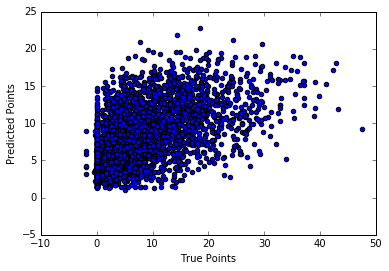

In [96]:
#Train a Linear regression model
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=-1)
lm.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Points")
plt.ylabel("Predicted Points")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'RMSE:', np.sqrt(mse)
print 'Mean Absolute Error: ', np.mean((Y_cv - lm.predict(X_cv)))
print 'Mean Relative Error: ', np.mean((Y_cv - lm.predict(X_cv))/(lm.predict(X_cv)))
print 'Average Points:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))

# Try Support Vector Regression

[LibSVM]MSE: 6.69132608288
Average Yardage: 8.3752194211
Correlation:  (0.52319378143407347, 2.6357835086890941e-225)


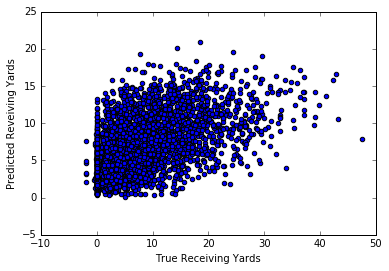

In [93]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
from sklearn import svm


lm=SVR(kernel='poly', degree=2, gamma='auto', \
       coef0=1000, tol=0.0001, C=0.1, epsilon=1,\
       shrinking=True, cache_size=200, verbose=True, max_iter=-1)

lm.fit(X_train,Y_train)


#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))


# Try Bayesian Ridge Regression

Convergence after  4  iterations
MSE: 6.56710229841
Average Yardage: 8.3752194211
Correlation:  (0.5231079262340772, 3.215273829954206e-225)


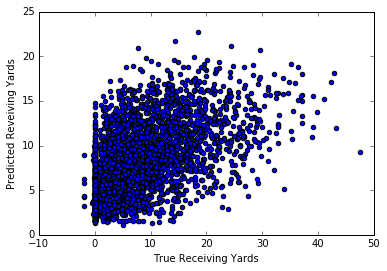

In [76]:
from sklearn.linear_model import BayesianRidge

lm = BayesianRidge(n_iter=100, tol=0.0001, alpha_1=1e10, \
                    alpha_2=1e0, lambda_1=1e06, lambda_2=1e-06,\
                    compute_score=False, fit_intercept=True, normalize=False,\
                    copy_X=True, verbose=True)

lm.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")

#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))


# Try Elastic Net

MSE: 6.56678203484
Average Yardage: 8.3752194211
Correlation:  0.523175769785


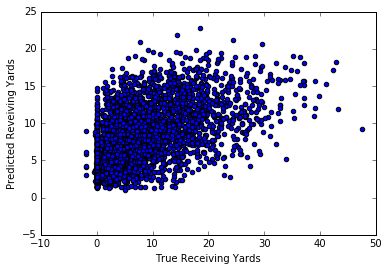

In [64]:
from sklearn.linear_model import ElasticNet

lm = ElasticNet(alpha=0.0001, l1_ratio=1, fit_intercept=False, \
                normalize=False, precompute=False, max_iter=1000000,\
                copy_X=True, tol=0.01, warm_start=False, positive=False,\
                random_state=None, selection='cyclic')

lm.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))[0]

